# Hopfield Sudoku

This is my attempt to use a Hopfield network to solve Sudokus. I took the instructions from Raúl Rojas excellent Neural Networks: A Systemic Introduction. In chapter 13, he shows how to solve the 8-Queens-Problem with Hopfield-Networks. 

### Nomenclature for Sudoku
Copied from Peter Norvig:
http://norvig.com/sudoku.html

Shown with a simple 4x4 Sudoku:

![alt-text](https://raw.githubusercontent.com/MaxRae/ConnectionistSudoku/master/Media/SudokuNomenclature.png)

## Sketch of the weights and connections between the units


![alt-text](https://raw.githubusercontent.com/MaxRae/ConnectionistSudoku/master/Media/HopfieldWeights.png)

If a unit is active, e.g. the top-left unit in the picture, it will have an inhibiting effect on all units within the same box, the same row and the same column, that are within the same layer (e.g. the layer for number 1). 

Not shown in the picture: An active unit in the layer for number 1 also has an inhibiting effect on units within the same square, that lie in the layers for numbers 2, 3 and 4. This makes sure that there can only be one number in each square of the Sudoku.

All units have threshold -1, so the inhibiting effect of another unit is enough to surpress the activity of all it's neighbouring units. 

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand

%matplotlib inline

## Setting up the units
One unit represents one proposition, for example "There is a 1 in the first square." A unit is either active or inactive (1 or 0).

The activation of units that are given (i.e. numbers that are already filled at the beginning) is clamped at 1.

In [0]:
class Unit:
    def __init__(self, activation, index):
        self.activation = activation
        self.index = index
        self.activation_history = [self.activation]
        
    def update(self, weights, activations,  threshold):
        """Simply the updating rule"""
        i,j,k = self.index
        previous_activation = self.activation
        #print("index: ", i,j,k)
        #print("before: ", previous_activation)
        net = sum(sum(sum(weights[i,j,k] * activations)))
        if net > threshold:
            self.activation = 1
        elif net < threshold: 
            self.activation = 0
        else:
            pass
        self.activation_history.append(self.activation)
        #print("net: ", net)
        #print("after: ", self.activation)
        if previous_activation == self.activation:
            return True
        
            
class ClampedUnit(Unit):
    '''So called evidence units whose activation is fixed
    In our case the sudoku numbers filled from the start'''
    
    def update(self, *args, **kwargs):
        self.activation_history.append(self.activation)
        return "Clamped!"
            
          

## Setting up the Hopfield network
We need to specify the weights between all units, initiliaze all units and clamped units and then be able to update their activation according to the weights between the units.

In [0]:
def get_boxindeces(size):
    """Reused code for getting i,j indexes of the squares in the boxes in a 
    Sudoku. Writing this caused some brain strain."""
    boxindeces = []
    blocklength = int(np.sqrt(size))
    for m in range(0, size, blocklength):
        for n in range(0, size, blocklength):
            box = []
            for k in range(0, blocklength):
                box.append((m+k,n))
                for l in range(1, blocklength):
                    box.append((m+k, n+l))
            boxindeces.append(box)
    return boxindeces

In [0]:
class Hopfield:
    def __init__(self, sudoku, threshold=-1):
        self.threshold = threshold
        # Sudoku is passed like this:
        # example4x4 = [[0., 1., 0., 0.], [0., 0., 0., 1.], ...]
        # = 2 in first and a 4 in second square
        self.size = len(sudoku[0]) # this should be 4, for the example
        
        # create a list of units, where one unit corresponds to a proposition
        # e.g. unit 1 = "There is a 1 at position [1,1]"
        self.units = []
        # m corresponds to the number of the square counted from top left 
        # to right row-wise
        # If the square already has a number, this unit's activation is clamped at 1
        for m, square in enumerate(sudoku):
            i, j = m//self.size, m%self.size
            for k, number in enumerate(square):
                activation = 0
                if not number and not any(square):
                    self.units.append(Unit(activation, index=(i,j,k)))
                elif number == 1:
                    self.units.append(ClampedUnit(activation = 1, index=(i,j,k)))
                elif not number and any(square):
                    self.units.append(ClampedUnit(activation = 0, index=(i,j,k)))
                else:
                    raise ValueError('An...unacceptable...condition!')
        
        self.weight_init()
        
    def weight_init(self):
        """Initialize the weight matrix
        For example, having a 4 in one square should inhibit all 4 units in
        the same column, row and box."""
        # for format of the weights, see above picture 
        # weights[i,j,k] gives you a 3D matrix of the weights between the unit at
        # i,j,k and all other units
        size = self.size
        self.weights = np.zeros([size]*6)
        # getting the indeces for the squares in the n boxes of the sudoku
        boxindeces = get_boxindeces(size)
        
        zero2size = list(range(size))
        # iterating through the 3D Sudoku, see picture above
        positions = itertools.product(zero2size, zero2size, zero2size)
        for i,j,k in positions:
            # First: inhibition within one square
            for number in zero2size:
                self.weights[i,j,k,i,j,number] = -2

            # Second: inhibition withing a box
            # index tells us in which box our current square lies
            index = [x for x,y in enumerate(boxindeces) if (i,j) in y][0]
            currentbox = boxindeces[index]
            for (square_i, square_j) in currentbox:
                self.weights[i,j,k,square_i,square_j,k] = -2

            # Third: inhibitions in rows and columns
            for l in zero2size:
                self.weights[i,j,k,l,j,k] = -2 #first the column
                self.weights[i,j,k,i,l,k] = -2 #then the row
                
            # Fourth: remove self-inhibition
            self.weights[i,j,k,i,j,k] = 0
                                
        
    def weight_update():
        """Wait, I don't update the weights, only the activations"""
        pass
    
    def return_activations(self):
        """Returns the activations of all units in a 3D matrix"""
        zero2size = list(range(self.size))
        activations = np.zeros([self.size]*3)
        
        # iterating through the 3D Sudoku, see picture above
        positions = itertools.product(zero2size, zero2size, zero2size)
        for n,ijk in enumerate(positions):
            i,j,k = ijk
            activations[i][j][k] = self.units[n].activation
        return activations
        
    def activation_update(self):
        """Updating the activations of all units in one step"""
        activations = self.return_activations()
        
        unit = self.units[rand.randint(0, len(self.units))]
        
        activations_unchanged = unit.update(self.weights, activations, 
                              threshold=self.threshold)
        #print(self.return_activations())
        return activations_unchanged
    
    def run_network(self, patience = 10):
        no_changes_since = 0
        while no_changes_since < patience:
            no_changes = self.activation_update()
            if no_changes:
                no_changes_since += 1
            elif no_changes == "Clamped!":
                pass
            else:
                no_changes_since = 0
            #print("no_changes_since: ", no_changes_since)
            

    def plot_activation_history(self):
        zero2size = list(range(self.size))
        positions = itertools.product(zero2size, zero2size)
        print(self.size)
        fig, ax = plt.subplots(self.size,self.size, figsize=(2*self.size, 2*self.size))
        fig.suptitle("History of activations for the numbers in all squares of the sudoku")
        ncols = nrows = self.size
        for i, index in enumerate(positions):
            for number in range(self.size):
                history = self.units[i*self.size+number].activation_history
                history.extend([history[-1]]*5)
                ax[index].plot(range(len(history)), history)#, c=colors[number])
                ax[index].set_ylim((-.5,1.1))
                ax[index].set_yticks([])
                ax[index].text(len(history), history[-1], "{}".format(number+1), 
                              bbox=dict(facecolor="white"))
                if history[-1] == 1 and history[0] == 0:
                    ax[index].text(0,0, "{}".format(number+1), fontsize=40, 
                             bbox=dict(facecolor="#FFF7C4"))
                if history[0] == 1:
                    ax[index].text(0,0, "{}".format(number+1), fontsize=40, 
                             bbox=dict(facecolor="white"))
        ax[-1, -1].text(-15, -1.7, "Yellow box: Number is set by the Hopfield-Network.")
        ax[-1, -1].text(-15, -2, "White box: Number was filled in from the start.")
                    
    

## Running a few example Sudokus

In [0]:
def to_binary(sudoku):
    new = np.zeros((len(sudoku), int(np.sqrt(len(sudoku)))))
    for i, entry in enumerate(sudoku):
        if entry == 0: continue
        new[i, int(entry-1)] = 1
    return new

sudo = [1,2,3,4,
        0,0,0,0,
        0,0,0,0,
        0,1,2,0]
example4x4 = to_binary(sudo)

sudo = [5,3,0,0,7,0,0,0,0,
       6,0,0,1,9,5,0,0,0,
       0,9,8,0,0,0,0,6,0,
       8,0,0,0,6,0,0,0,3,
       4,0,0,8,0,3,0,0,1,
       7,0,0,0,2,0,0,0,6,
       0,6,0,0,0,0,2,8,0,
       0,0,0,4,1,9,0,0,5,
       0,0,0,0,8,0,0,7,9]
example9x9 = to_binary(sudo)

sudo = [5,3,4,6,7,8,9,1,2,
              6,7,2,1,9,5,3,4,8,
              1,9,8,3,4,2,5,6,7,
              8,5,9,7,6,1,4,2,3,
              4,2,6,8,5,3,7,9,1,
              7,1,3,9,2,4,8,5,6,
              9,6,1,5,3,7,2,8,4,
              2,8,7,4,1,9,6,3,5,
              3,4,5,2,8,6,1,7,9]
example9x9_solved = to_binary(sudo)

### 4x4 Sudoku

4


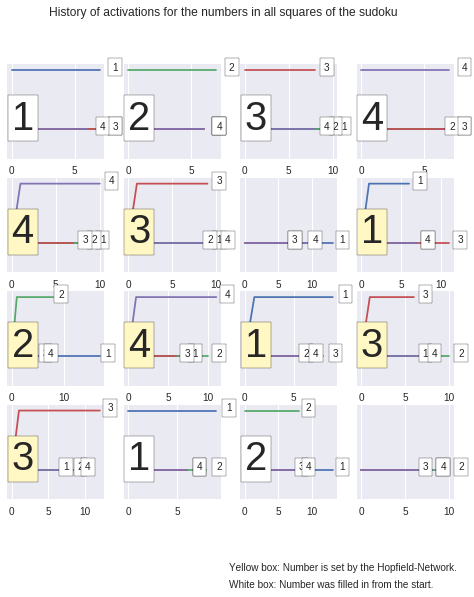

In [101]:
sudoku1 = Hopfield(example4x4, threshold=-1)
sudoku1.run_network(patience=50)

sudoku1.plot_activation_history()

### 9x9 Sudoku

9


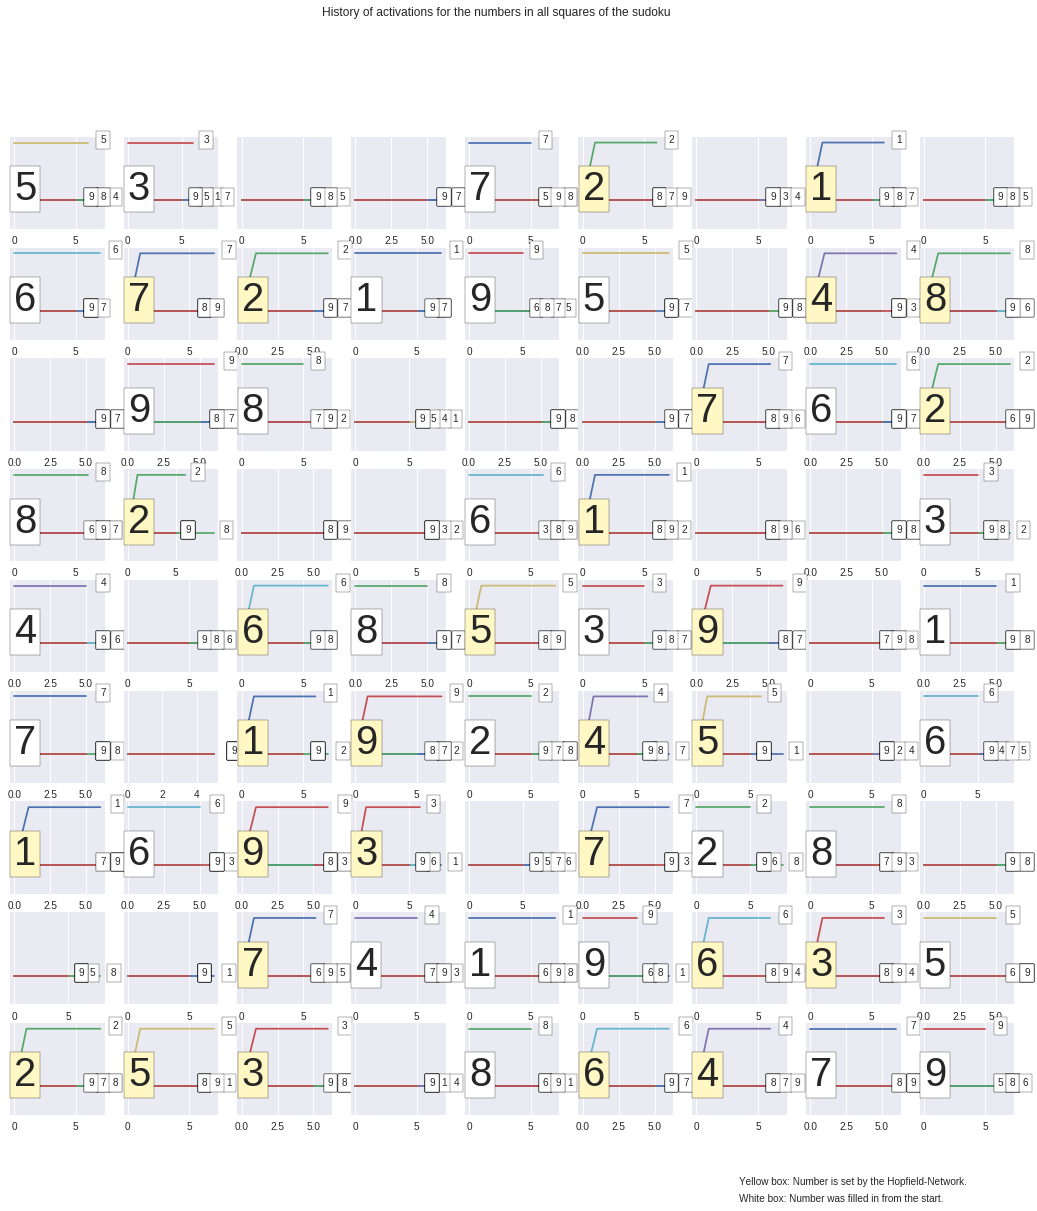

In [102]:
sudoku2 = Hopfield(example9x9, threshold=-1)
sudoku2.run_network(patience=50)

sudoku2.plot_activation_history()

## Observations

- the Hopfield network always gets stuck in a local minima
 - no number is in conflict with any other number
 - every empty field has no number that is not in conflict with a number in another square

## Discussion

- In retrospect it could have been clear that this local minima exist 
 - Raúl Rojas even mentioned the solution: If the network converges into an unsolved Sudoku, randomly switch the activation of one unit and run again
  - this solution will clearly converge, but it also feels much less elegant
